In [1]:
import os, pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.applications import ResNet50
from keras.utils import load_img
from sklearn.utils import shuffle
import keras
import cv2
from matplotlib import pyplot as plt


First we load the datasets

In [2]:
train_imgs = []
train_labels = []
all_labels = {}
cnt = 0;
for directory in os.listdir("./refactored_all/train"):
    all_labels[cnt] = directory
    train_labels.append(list(np.full(len(os.listdir("./refactored_all/train/"+directory)),directory)))
    for file in os.listdir("./refactored_all/train/"+directory):
        img = cv2.normalize(np.array(load_img("./refactored_all/train/"+directory+"/"+file)),None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        train_imgs.append(img)
    cnt += 1
    print(cnt,end=';')
train_labels = np.concatenate(train_labels)

1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;

In [3]:
validation_imgs = []
validation_labels = []
for directory in os.listdir("./refactored_all/validation"):
    validation_labels.append(list(np.full(len(os.listdir("./refactored_all/validation/"+directory)),directory)))
    for file in os.listdir("./refactored_all/validation/"+directory):
        img = cv2.normalize(np.array(load_img("./refactored_all/validation/"+directory+"/"+file)),None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        validation_imgs.append(img)
validation_labels = np.concatenate(validation_labels)

We use one-hot encoding on labels

In [4]:
for label in all_labels:
    train_labels = [label if x == all_labels[label] else x for x in train_labels]
    validation_labels = [label if x == all_labels[label] else x for x in validation_labels]
train_imgs, train_labels = shuffle(train_imgs, train_labels)
validation_imgs, validation_labels = shuffle(validation_imgs, validation_labels)

In [5]:
train_imgs = np.array(train_imgs)
validation_imgs = np.array(validation_imgs)
train_imgs.shape

(3430, 128, 128, 3)

First we try to learn the network on the original data

In [6]:
import tensorflow as tf



input_data = keras.Input(dtype=tf.float32, shape = ( train_imgs.shape[1], train_imgs.shape[2], 3))
input_labels = keras.Input(dtype = tf.int32, shape = (None, 1))

batch_norm1 = keras.layers.BatchNormalization()
batch_norm2 = keras.layers.BatchNormalization()
batch_norm3 = keras.layers.BatchNormalization()
batch_norm4 = keras.layers.BatchNormalization()

batch_norm5 = keras.layers.BatchNormalization()
batch_norm6 = keras.layers.BatchNormalization()


conv1 = keras.layers.Conv2D(16, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)
pool = keras.layers.MaxPooling2D((2, 2), (2, 2))

conv2 = keras.layers.Conv2D(32, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv3 = keras.layers.Conv2D(64, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv4 = keras.layers.Conv2D(256, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv5 = keras.layers.Conv2D(512, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv6 = keras.layers.Conv2D(1024, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)


drop = keras.layers.Dropout(0.5)

activ = keras.layers.Activation("relu")
logits = keras.layers.Dense(len(all_labels.keys()),activation="softmax")
glob_pool = keras.layers.GlobalAveragePooling2D()
model = keras.models.Sequential()
model.add(input_data)

model.add(activ)
model.add(conv1)
model.add(batch_norm1)
model.add(pool)

model.add(activ)
model.add(conv2)
model.add(batch_norm2)
model.add(pool)


model.add(activ)
model.add(conv3)
model.add(batch_norm3)
model.add(pool)

model.add(activ)
model.add(conv4)
model.add(batch_norm4)
model.add(pool)


model.add(activ)
model.add(conv5)
model.add(batch_norm5)
model.add(pool)

model.add(activ)
model.add(conv6)
model.add(batch_norm6)
model.add(pool)



model.add(glob_pool)
model.add(drop)
model.add(logits)

In [7]:
model.build((None, train_imgs.shape[1], train_imgs.shape[2], 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 activation (Activation)     multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       1

In [8]:
lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=["accuracy"])



In [9]:
hist_basic = model.fit(
   train_imgs,np.array(train_labels), 
   batch_size = 10,
   epochs = 25,
    callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_basic.keras"),
],
    validation_data=(validation_imgs,np.array(validation_labels))
)

Epoch 1/25
343/343 [==============================] - 14s 11ms/step - loss: 5.0232 - accuracy: 0.0324 - val_loss: 4.1237 - val_accuracy: 0.0292
Epoch 2/25
343/343 [==============================] - 3s 10ms/step - loss: 4.2100 - accuracy: 0.0621 - val_loss: 3.9174 - val_accuracy: 0.0763
Epoch 3/25
343/343 [==============================] - 3s 9ms/step - loss: 3.7124 - accuracy: 0.0994 - val_loss: 3.9816 - val_accuracy: 0.0810
Epoch 4/25
343/343 [==============================] - 3s 9ms/step - loss: 3.3445 - accuracy: 0.1504 - val_loss: 3.8536 - val_accuracy: 0.0995
Epoch 5/25
343/343 [==============================] - 3s 9ms/step - loss: 2.9990 - accuracy: 0.2251 - val_loss: 3.8750 - val_accuracy: 0.1088
Epoch 6/25
343/343 [==============================] - 3s 9ms/step - loss: 2.4926 - accuracy: 0.3262 - val_loss: 3.4916 - val_accuracy: 0.1599
Epoch 7/25
343/343 [==============================] - 3s 9ms/step - loss: 1.9107 - accuracy: 0.4778 - val_loss: 4.3708 - val_accuracy: 0.1433
Epo

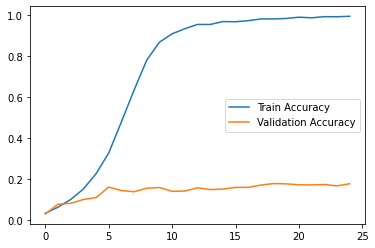

In [10]:
plt.plot(hist_basic.history['accuracy'],label='Train Accuracy')
plt.plot(hist_basic.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

Saliency mask class inspired by https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py


In [11]:
class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=1):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros((input_image.shape[1:3]), dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += np.reshape(self.get_mask(x_value_plus_noise),input_image.shape[1:3])
        return total_gradients / nsamples
    
class VisualBackprop(SaliencyMask):
    def __init__(self, model, output_index = 0):
        inps = [model.input]           # input placeholder
        outs = [layer.output for layer in model.layers]    # all layer outputs
        self.forward_pass = keras.backend.function(inps, outs)         # evaluation function
        
        self.model = model

    def get_mask(self, input_image):
        x_value = input_image
        
        visual_bpr = []
        layer_outs = self.forward_pass([x_value])
        for i in range(len(self.model.layers) - 1, -1, -1):
            if 'Conv2D' in str(type(self.model.layers[i])):
                layer = np.mean(layer_outs[i], axis = -1, keepdims = True)
                layer = layer - np.min(layer)
                layer = layer / (np.max(layer) - np.min(layer) + 1e-6)
                if np.array(visual_bpr).size != 0:
                    if visual_bpr.shape != layer.shape:
                        visual_bpr = self._deconv(visual_bpr)
                    visual_bpr = visual_bpr * layer
                else:
                    visual_bpr = np.array(layer)
        return visual_bpr[0]
    
    def _deconv(self, feature_map):
        x = keras.layers.Input(shape = (None, None, 1))
        y = keras.layers.Conv2DTranspose(filters = 1, 
                            kernel_size = (3, 3), 
                            strides = (2, 2), 
                            padding = 'same', 
                            kernel_initializer = keras.initializers.Ones(), 
                            bias_initializer = keras.initializers.Zeros())(x)

        deconv_model = keras.models.Model(inputs=[x], outputs=[y])
        inps = [deconv_model.input]   
        outs = [deconv_model.layers[-1].output]
        deconv_func = keras.backend.function(inps, outs)
        
        return deconv_func([feature_map])[0]


Now we perform augmentation - from each foto we get 15 new samples

In [14]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation((0,90))
            ]
)

In [15]:
aug_train_imgs = []
aug_train_labels = []
for img_index in range (len(train_labels)):
    if img_index % 100 == 0:
      print(img_index,end=';')
    for i in range (15):
        aug_train_labels.append(train_labels[img_index])
        aug_train_imgs.append(data_augmentation(train_imgs[img_index]))

0;100;200;300;400;500;600;700;800;900;1000;1100;1200;1300;1400;1500;1600;1700;1800;1900;2000;2100;2200;2300;2400;2500;2600;2700;2800;2900;3000;3100;3200;3300;3400;

In [16]:
aug_train_imgs = np.array(aug_train_imgs)
validation_imgs = np.array(validation_imgs)
aug_train_imgs, aug_train_labels = shuffle(aug_train_imgs, aug_train_labels)
validation_imgs, validation_labels = shuffle(validation_imgs, validation_labels)

Training on augmented data

In [1]:
import tensorflow as tf



input_data = keras.Input(dtype=tf.float32, shape = ( train_imgs.shape[1], train_imgs.shape[2], 3))
input_labels = keras.Input(dtype = tf.int32, shape = (None, 1))

batch_norm1 = keras.layers.BatchNormalization()
batch_norm2 = keras.layers.BatchNormalization()
batch_norm3 = keras.layers.BatchNormalization()
batch_norm4 = keras.layers.BatchNormalization()
batch_norm5 = keras.layers.BatchNormalization()
batch_norm6 = keras.layers.BatchNormalization()




conv1 = keras.layers.Conv2D(32, (3, 3), (1, 1),padding = "same",  activation=tf.nn.relu)
pool1 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool2 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool3 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool4 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool5 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool6 = keras.layers.MaxPooling2D((2, 2), (2, 2))


conv2 = keras.layers.Conv2D(32, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv3 = keras.layers.Conv2D(64, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv4 = keras.layers.Conv2D(256, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv5 = keras.layers.Conv2D(512, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv6 = keras.layers.Conv2D(1024, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)


drop = keras.layers.Dropout(0.50)

logits = keras.layers.Dense(len(all_labels.keys()),activation="softmax", kernel_regularizer='l1')
glob_pool = keras.layers.GlobalAveragePooling2D()
model = keras.models.Sequential()
model.add(input_data)

model.add(conv1)
model.add(batch_norm1)
#model.add(conv1a)

model.add(pool1)

model.add(conv2)
model.add(batch_norm2)
#model.add(conv2a)
model.add(pool2)


model.add(conv3)
model.add(batch_norm3)
model.add(pool3)

#model.add(conv3a)


model.add(conv4)
model.add(batch_norm4)
model.add(pool4)

model.add(conv5)
model.add(batch_norm5)
model.add(pool5)

model.add(conv6)
model.add(batch_norm6)
model.add(pool6)

model.add(glob_pool)
model.add(drop)
model.add(logits)

KeyboardInterrupt: 

In [18]:
lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=["accuracy"])



In [19]:
hist_augmented = model.fit(
   aug_train_imgs,np.array(aug_train_labels), 
   batch_size = 30,
   epochs = 15,

    callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_augmented.keras"),
],
    validation_data=(validation_imgs,np.array(validation_labels))
)

Epoch 1/15
1715/1715 [==============================] - 20s 11ms/step - loss: 4.3697 - accuracy: 0.3780 - val_loss: 4.4206 - val_accuracy: 0.2050
Epoch 2/15
1715/1715 [==============================] - 18s 11ms/step - loss: 1.7849 - accuracy: 0.8073 - val_loss: 4.3204 - val_accuracy: 0.1772
Epoch 3/15
1715/1715 [==============================] - 19s 11ms/step - loss: 1.2073 - accuracy: 0.9039 - val_loss: 4.1323 - val_accuracy: 0.1845
Epoch 4/15
1715/1715 [==============================] - 19s 11ms/step - loss: 0.9527 - accuracy: 0.9478 - val_loss: 4.0184 - val_accuracy: 0.1818
Epoch 5/15
1715/1715 [==============================] - 18s 11ms/step - loss: 0.7766 - accuracy: 0.9739 - val_loss: 3.9224 - val_accuracy: 0.1898
Epoch 6/15
1715/1715 [==============================] - 18s 11ms/step - loss: 0.6678 - accuracy: 0.9842 - val_loss: 3.8699 - val_accuracy: 0.2077
Epoch 7/15
1715/1715 [==============================] - 18s 11ms/step - loss: 0.5890 - accuracy: 0.9910 - val_loss: 3.8767 -

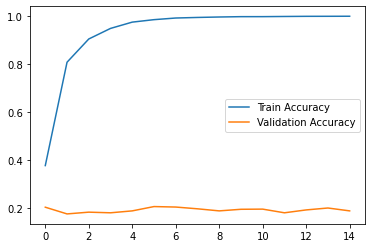

In [20]:
plt.plot(hist_augmented.history['accuracy'],label='Train Accuracy')
plt.plot(hist_augmented.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

We load the model for saliency based crop

In [7]:
model = keras.models.load_model("saliency_crop_model.h5")

We create new photos and merge it with the original ones

In [12]:
new_train_imgs = []

for i in range(0,train_imgs.shape[0]):
  if i % 100 == 0:
    print(i,end=';')
  img = np.array([train_imgs[i]])
  label = train_labels[i]
  vanilla = VisualBackprop(model, label)
  smooth_mask = vanilla.get_smoothed_mask(img)

  tobin = np.array(smooth_mask, dtype = np.uint8)
  binarized = cv2.adaptiveThreshold(tobin, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 351, -0.1)

  contours = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  coords = cv2.findNonZero(binarized)
  x,y,w,h = cv2.boundingRect(coords)
  cropped_image = img[0][min(y,img[0].shape[0] - max(h,w)):min(img[0].shape[0],y+max(h,w)), min(x,img[0].shape[1] - max(h,w)):min(img[0].shape[1],x+max(h,w)),:]
  if cropped_image.shape[0]<img[0].shape[0]/4:
    cropped_image = img[0]
  cropped_image = cv2.normalize(cropped_image,None,alpha = 0, beta = 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
  cropped_image = cv2.resize(cropped_image,(128,128), interpolation = cv2.INTER_LINEAR)
  new_train_imgs.append(cropped_image)


0;100;200;300;400;500;600;700;800;900;1000;1100;1200;1300;1400;1500;1600;1700;1800;1900;2000;2100;2200;2300;2400;2500;2600;2700;2800;2900;3000;3100;3200;3300;3400;

In [13]:
train_imgs = np.concatenate((train_imgs, np.array(new_train_imgs)))
train_labels += train_labels

In [14]:
train_imgs = np.array(train_imgs)
train_imgs.shape

(6860, 128, 128, 3)

Now we try to teach the model on new data

In [36]:
import tensorflow as tf
input_data = keras.Input(dtype=tf.float32, shape = ( train_imgs.shape[1], train_imgs.shape[2], 3))
input_labels = keras.Input(dtype = tf.int32, shape = (None, 1))

batch_norm1 = keras.layers.BatchNormalization()
batch_norm2 = keras.layers.BatchNormalization()
batch_norm3 = keras.layers.BatchNormalization()
batch_norm4 = keras.layers.BatchNormalization()

batch_norm5 = keras.layers.BatchNormalization()
batch_norm6 = keras.layers.BatchNormalization()


conv1 = keras.layers.Conv2D(16, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)
pool = keras.layers.MaxPooling2D((2, 2), (2, 2))

conv2 = keras.layers.Conv2D(32, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv3 = keras.layers.Conv2D(64, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv4 = keras.layers.Conv2D(256, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv5 = keras.layers.Conv2D(512, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv6 = keras.layers.Conv2D(1024, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)


drop = keras.layers.Dropout(0.5)

activ = keras.layers.Activation("relu")
logits = keras.layers.Dense(len(all_labels.keys()),activation="softmax")
glob_pool = keras.layers.GlobalAveragePooling2D()
model_crop = keras.models.Sequential()
model_crop.add(input_data)

model_crop.add(activ)
model_crop.add(conv1)
model_crop.add(batch_norm1)
model_crop.add(pool)

model_crop.add(activ)
model_crop.add(conv2)
model_crop.add(batch_norm2)
model_crop.add(pool)


model_crop.add(activ)
model_crop.add(conv3)
model_crop.add(batch_norm3)
model_crop.add(pool)

model_crop.add(activ)
model_crop.add(conv4)
model_crop.add(batch_norm4)
model_crop.add(pool)


model_crop.add(activ)
model_crop.add(conv5)
model_crop.add(batch_norm5)
model_crop.add(pool)

model_crop.add(activ)
model_crop.add(conv6)
model_crop.add(batch_norm6)
model_crop.add(pool)



model_crop.add(glob_pool)
model_crop.add(drop)
model_crop.add(logits)

In [37]:
lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9)
model_crop.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=["accuracy"])


In [38]:
hist_basic = model_crop.fit(
   train_imgs,np.array(train_labels), 
   batch_size = 10,
   epochs = 70,
    callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_basic.keras"),
],
    validation_data=(validation_imgs,np.array(validation_labels))
)

Epoch 1/70
686/686 [==============================] - 7s 9ms/step - loss: 5.0445 - accuracy: 0.0162 - val_loss: 4.0947 - val_accuracy: 0.0199
Epoch 2/70
686/686 [==============================] - 6s 8ms/step - loss: 4.6886 - accuracy: 0.0191 - val_loss: 4.1125 - val_accuracy: 0.0179
Epoch 3/70
686/686 [==============================] - 6s 8ms/step - loss: 4.4435 - accuracy: 0.0195 - val_loss: 4.0828 - val_accuracy: 0.0219
Epoch 4/70
686/686 [==============================] - 6s 8ms/step - loss: 4.2840 - accuracy: 0.0194 - val_loss: 4.0767 - val_accuracy: 0.0325
Epoch 5/70
686/686 [==============================] - 6s 8ms/step - loss: 4.2061 - accuracy: 0.0200 - val_loss: 4.0671 - val_accuracy: 0.0265
Epoch 6/70
686/686 [==============================] - 6s 8ms/step - loss: 4.1675 - accuracy: 0.0249 - val_loss: 4.0055 - val_accuracy: 0.0338
Epoch 7/70
686/686 [==============================] - 6s 8ms/step - loss: 4.1182 - accuracy: 0.0227 - val_loss: 3.9527 - val_accuracy: 0.0365
Epoch 

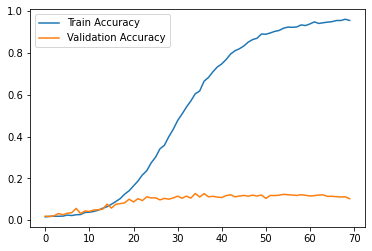

In [39]:
plt.plot(hist_basic.history['accuracy'],label='Train Accuracy')
plt.plot(hist_basic.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [15]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation((0,90))
            ]
)

In [16]:
aug_train_imgs = []
aug_train_labels = []
for img_index in range (len(train_labels)):
    if img_index % 100 == 0:
      print(img_index,end=';')
    for i in range (10):
        aug_train_labels.append(train_labels[img_index])
        aug_train_imgs.append(data_augmentation(train_imgs[img_index]))

0;100;200;300;400;500;600;700;800;900;1000;1100;1200;1300;1400;1500;1600;1700;1800;1900;2000;2100;2200;2300;2400;2500;2600;2700;2800;2900;3000;3100;3200;3300;3400;3500;3600;3700;3800;3900;4000;4100;4200;4300;4400;4500;4600;4700;4800;4900;5000;5100;5200;5300;5400;5500;5600;5700;5800;5900;6000;6100;6200;6300;6400;6500;6600;6700;6800;

In [17]:
aug_train_imgs = np.array(aug_train_imgs)


Finally, we perform the learning on the augmented and transformed data

In [18]:


input_data = keras.Input(dtype=tf.float32, shape = ( aug_train_imgs.shape[1], aug_train_imgs.shape[2], 3))
input_labels = keras.Input(dtype = tf.int32, shape = (None, 1))

batch_norm1 = keras.layers.BatchNormalization()
batch_norm2 = keras.layers.BatchNormalization()
batch_norm3 = keras.layers.BatchNormalization()
batch_norm4 = keras.layers.BatchNormalization()
batch_norm5 = keras.layers.BatchNormalization()
batch_norm6 = keras.layers.BatchNormalization()




conv1 = keras.layers.Conv2D(32, (3, 3), (1, 1),padding = "same",  activation=tf.nn.relu)
pool1 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool2 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool3 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool4 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool5 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool6 = keras.layers.MaxPooling2D((2, 2), (2, 2))


conv2 = keras.layers.Conv2D(32, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv3 = keras.layers.Conv2D(64, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv4 = keras.layers.Conv2D(256, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv5 = keras.layers.Conv2D(512, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv6 = keras.layers.Conv2D(1024, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)


drop = keras.layers.Dropout(0.50)

logits = keras.layers.Dense(len(all_labels.keys()),activation="softmax", kernel_regularizer='l1')
glob_pool = keras.layers.GlobalAveragePooling2D()
model = keras.models.Sequential()
model.add(input_data)

model.add(conv1)
model.add(batch_norm1)
#model.add(conv1a)

model.add(pool1)

model.add(conv2)
model.add(batch_norm2)
#model.add(conv2a)
model.add(pool2)


model.add(conv3)
model.add(batch_norm3)
model.add(pool3)

#model.add(conv3a)


model.add(conv4)
model.add(batch_norm4)
model.add(pool4)

model.add(conv5)
model.add(batch_norm5)
model.add(pool5)

model.add(conv6)
model.add(batch_norm6)
model.add(pool6)

model.add(glob_pool)
model.add(drop)
model.add(logits)

In [19]:
lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=["accuracy"])




In [20]:
hist_augmented = model.fit(
   aug_train_imgs,np.array(aug_train_labels), 
   batch_size = 30,
   epochs = 15,

    callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_augmented.keras"),
],
    validation_data=(validation_imgs,np.array(validation_labels))
)

Epoch 1/15
2287/2287 [==============================] - 27s 11ms/step - loss: 5.1710 - accuracy: 0.0439 - val_loss: 4.4432 - val_accuracy: 0.0418
Epoch 2/15
2287/2287 [==============================] - 25s 11ms/step - loss: 4.0824 - accuracy: 0.1504 - val_loss: 4.2407 - val_accuracy: 0.1294
Epoch 3/15
2287/2287 [==============================] - 25s 11ms/step - loss: 3.2940 - accuracy: 0.3845 - val_loss: 4.4642 - val_accuracy: 0.1871
Epoch 4/15
2287/2287 [==============================] - 25s 11ms/step - loss: 2.4468 - accuracy: 0.6198 - val_loss: 4.4625 - val_accuracy: 0.1553
Epoch 5/15
2287/2287 [==============================] - 25s 11ms/step - loss: 1.8528 - accuracy: 0.7691 - val_loss: 4.4378 - val_accuracy: 0.1347
Epoch 6/15
2287/2287 [==============================] - 25s 11ms/step - loss: 1.4765 - accuracy: 0.8509 - val_loss: 4.4655 - val_accuracy: 0.1573
Epoch 7/15
2287/2287 [==============================] - 26s 11ms/step - loss: 1.2266 - accuracy: 0.8970 - val_loss: 4.4270 -

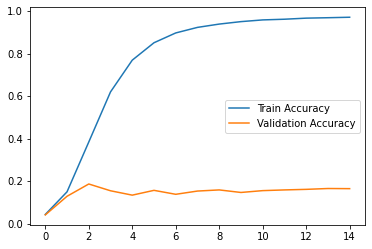

In [21]:
plt.plot(hist_augmented.history['accuracy'],label='Train Accuracy')
plt.plot(hist_augmented.history['val_accuracy'],label='Validation Accuracy')
plt.legend()